In [1]:
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from IPython.display import display

aln = 'mm2'
benchmark_d = {
    'mb': {
        'path': 'mb/eval/batch1-{c}-annotated-{aln}_bcftools_isec',
        'callers': ['ensemble', 'strelka2', 'vardict', 'mutect2'],
    },
    'giab': {
        'path': 'giab/eval/UtahMormon-1-{aln}-{c}-annotated_bcftools_isec',
        'callers': ['ensemble', 'strelka2', 'vardict', 'gatk-haplotype'],
    },
    'colo': {
        'path': 'colo/eval/COLO_TGEN_{aln}-{c}-annotated_bcftools_isec',
        'callers': ['ensemble', 'strelka2', 'vardict', 'mutect2'],
    }
}
for n, b in benchmark_d.items(): 
    b['name'] = n

benchmarks_names = ['mb', 'colo']
#benchmarks_names = ['mb']
benchmarks = [benchmark_d[n] for n in benchmarks_names]
CALLER = 'strelka2'
callers = ['ensemble']

l = 's'
r = 'e'
left = CALLER
right = 'ensemble'


In [3]:
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from os.path import join
from collections import Counter

df_by_benchmark = dict()

for b in benchmarks:
    print(f'Parsing data for benchmark {b["name"]}')
    vcfs = defaultdict(dict)
    for c in callers:
        vcfs[c] = dict(
            fp=join(b['path'].format(aln=aln, c=c), '0000.vcf'),
            fn=join(b['path'].format(aln=aln, c=c), '0001.vcf'),
            tp=join(b['path'].format(aln=aln, c=c), '0002.vcf'),    
        )
        
    main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

    recs_by_loc = defaultdict(lambda: {c: (None, 'tn') for c in callers})
    for caller in callers:
        print(f'  Parsing VCFs for {caller}...')
        for typ, vcf in vcfs[caller].items():
            print(f'  reading {vcf}')
            for rec in VCF(vcf):    
#                if rec.CHROM != '21':
#                    continue
                k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                recs_by_loc[k][caller] = rec, typ

    print(f'  Analysing data, building dataframe...')
    total = 0
    rows = []
    for (chrom, pos, ref, alt), d in recs_by_loc.items():
        assert any(d[c] for c in callers)
        total += 1

        fields = dict()
        if len(callers) > 1:
            s_rec, s_typ = d[CALLER]
            e_rec, e_typ = d['ensemble']
            rec = s_rec if (s_typ in ['tp', 'fp']) else e_rec
            assert rec, dbg.set_trace()
            assert e_typ, dbg.set_trace()
            assert s_typ, dbg.set_trace()
            fields['s_typ'] = s_typ
            fields['e_typ'] = e_typ
            fields['is_common'] = e_typ in ['tp', 'fp'] and s_typ in ['tp', 'fp']
        else:
            rec, typ = d['ensemble']
            fields['typ'] = typ

        for tag in ['AF', 'DP', 'MQ']:
            for ph in ['TUMOR', 'NORMAL']:
                v = rec.INFO.get(f'{ph}_{tag}')
                if v is not None:
                    fields[f'{ph}_{tag}'] = v
        fields[f'SomaticEVS'] = rec.INFO.get('SomaticEVS')
        fields[f'ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')

        tricky_anno = rec.INFO.get('TRICKY', '').split(',')
        tricky_anno = tuple([a for a in tricky_anno if a and a not in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']])

        gene = None
        ann = rec.INFO.get('ANN')
        if isinstance(ann, str):  # skip decomposed fields with lost ANN
            gene = ann.split('|')[3]
        
        row = {
            'chrom_pos': f'{rec.CHROM}:{rec.POS}',
            'benchmark': b['name'],
            'is_snp': rec.is_snp,
            'tricky_anno': tricky_anno,
            'gene': gene,
        }
        row.update(fields)
        rows.append(row)
    
    df_by_benchmark[b['name']] = pd.DataFrame(rows)
    print(f'  Done parsing {total} variants for benchmark {b["name"]}')
    print()

data = pd.concat(df_by_benchmark)

print('Done.')

Parsing data for benchmark mb
  Parsing VCFs for ensemble...
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0000.vcf
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0001.vcf
  reading mb/eval/batch1-ensemble-annotated-mm2_bcftools_isec/0002.vcf
  Analysing data, building dataframe...
  Done parsing 2180 variants for benchmark mb

Parsing data for benchmark colo
  Parsing VCFs for ensemble...
  reading colo/eval/COLO_TGEN_mm2-ensemble-annotated_bcftools_isec/0000.vcf
  reading colo/eval/COLO_TGEN_mm2-ensemble-annotated_bcftools_isec/0001.vcf
  reading colo/eval/COLO_TGEN_mm2-ensemble-annotated_bcftools_isec/0002.vcf
  Analysing data, building dataframe...
  Done parsing 44174 variants for benchmark colo

Done.


In [3]:
len(data[data['TUMOR_AF'] < 0.2].loc['mb'])

747

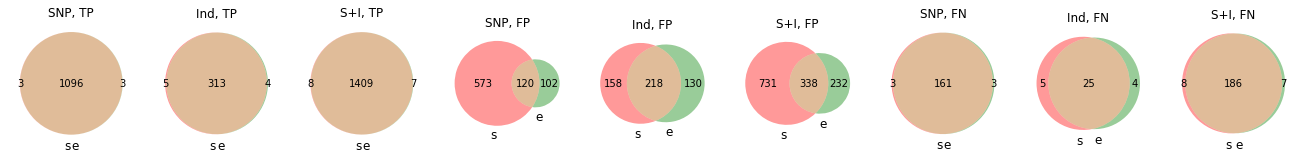

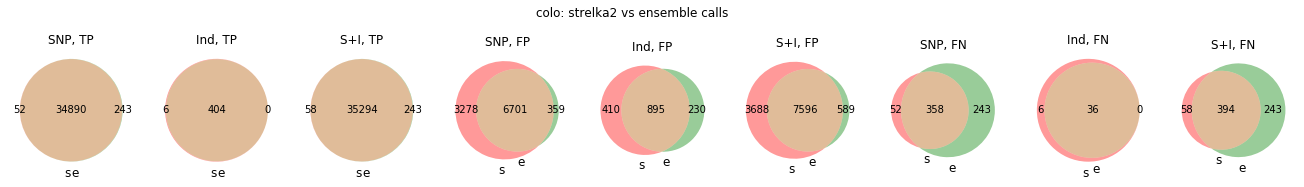

In [3]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib import gridspec

def get_category(x):
    return {
        ('tp', 'fn'): f'unique_tp_{l}',
        ('fn', 'tp'): f'unique_tp_{r}',
        ('fp', 'tn'): f'unique_fp_{l}',
        ('tn', 'fp'): f'unique_fp_{r}',  
        ('tp', 'tp'): 'common_tp',
        ('fp', 'fp'): 'common_fp',
        ('fn', 'fn'): 'common_fn'
    }[(x[f'{l}_typ'], x[f'{r}_typ'])]

data['category'] = data.apply(get_category, axis=1)

def plot_venn(data):
    for bn in benchmarks_names:
        stats_by_cat = Counter()
        for (is_snp, category), g in data.loc[bn].groupby(['is_snp', 'category']):
            stats_by_cat[(is_snp, category)] += len(g)

        # Plotting Venn diagrams   
        fig = plt.figure(figsize=(23, 3))
        grid = gridspec.GridSpec(1, 9, width_ratios=[1] * 9)
        """   snp  ind  all  
              tp      
              fp     
              tp+fp          """    
        all_tp_subsets = Counter()
        all_fp_subsets = Counter()
        all_fn_subsets = Counter()
        all_subsets = Counter()

        for is_snp_i, is_snp in enumerate([True, False]):
            lbl = 'SNP' if is_snp else 'Ind'

            tp_subsets = Counter({
                '10': stats_by_cat[(is_snp, f'unique_tp_{l}')],
                '01': stats_by_cat[(is_snp, f'unique_tp_{r}')],
                '11': stats_by_cat[(is_snp, f'common_tp')],
            })
            fp_subsets = Counter({
                '10': stats_by_cat[(is_snp, f'unique_fp_{l}')],
                '01': stats_by_cat[(is_snp, f'unique_fp_{r}')],
                '11': stats_by_cat[(is_snp, f'common_fp')],
            })        
            fn_subsets = Counter({
                '10': stats_by_cat[(is_snp, f'unique_tp_{l}')],
                '01': stats_by_cat[(is_snp, f'unique_tp_{r}')],
                '11': stats_by_cat[(is_snp, f'common_fn')],
            })
            subsets = tp_subsets + fp_subsets
            ax = plt.subplot(grid[0 + is_snp_i])
            venn2(tp_subsets, set_labels=(l, r), ax=ax)
            ax.set_title(f'{lbl}, TP')

            ax = plt.subplot(grid[3 + is_snp_i])
            venn2(fp_subsets, set_labels=(l, r), ax=ax)
            ax.set_title(f'{lbl}, FP')

            ax = plt.subplot(grid[6 + is_snp_i])
            venn2(fn_subsets, set_labels=(l, r), ax=ax)
            ax.set_title(f'{lbl}, FN')

            all_tp_subsets += tp_subsets
            all_fp_subsets += fp_subsets
            all_subsets += subsets 
            all_fn_subsets += fn_subsets

        ax = plt.subplot(grid[0 + 2])
        venn2(all_tp_subsets, set_labels=(l, r), ax=ax)
        ax.set_title(f'S+I, TP')

        ax = plt.subplot(grid[3 + 2])
        venn2(all_fp_subsets, set_labels=(l, r), ax=ax)
        ax.set_title(f'S+I, FP')

        ax = plt.subplot(grid[6 + 2])
        venn2(all_fn_subsets, set_labels=(l, r), ax=ax)
        ax.set_title(f'S+I, FN')

    plt.suptitle(f'{bn}: {left} vs {right} calls')

plot_venn(data)

In [8]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec

def plot_roc(df, roc_field, start, end, step=1, label_step=5, show_values=False, filt_fn=None):
    if filt_fn:
        df = df[df.apply(filt_fn, axis=1)]
    else:
        df = df

    for bn in benchmarks_names:
        print(f'Plotting {bn}')
        bdf = df.loc[bn]
        
        fig = plt.figure(figsize=(20, 10))
        grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        plt.suptitle(f'Benchmark {bn}')

        roc_ax = plt.subplot(grid[0], label=f'ROC {field.upper()}', title=f'ROC curve by {field.upper()}')
        roc_ax.set_xlabel('TPR')
        roc_ax.set_ylabel('FPR')
        plt.grid()

        tp_fp_ax = plt.subplot(grid[1], label=f'TP v FP {field.upper()}', title=f'TP v FP curve by {field.upper()}')  
        tp_fp_ax.set_xlabel(f'{field.upper()}')
        tp_fp_ax.set_ylabel('Calls')
        plt.grid()

        # Pre-calculation    
        tps_by_k, fps_by_k = defaultdict(list), defaultdict(list)
        precs_by_k, recalls_by_k = defaultdict(list), defaultdict(list)
        for k in [l, r]:
            vals = np.arange(start, end + step, step)
            for val in vals:
                val_df = bdf[bdf[f'{field}'] >= val]

                tp = len(val_df[val_df[f'{k}_typ'] == 'tp'])
                fn = len(val_df[val_df[f'{k}_typ'] == 'fn'])
                fp = len(val_df[val_df[f'{k}_typ'] == 'fp'])

                tps_by_k[k].append(tp)
                fps_by_k[k].append(fp)

                called = tp + fp
                precs_by_k[k].append(tp / called if called else 0)
                truth = tp + fn
                recalls_by_k[k].append(tp / truth if truth else 0)

        com, lfs, rts = [], [], []
        for val, l_tp, l_fp, r_tp, r_fp in zip(
            vals, tps_by_k[l], fps_by_k[l], tps_by_k[r], fps_by_k[r]):
            lfs.append([val, l_tp, l_fp])
            rts.append([val, r_tp, r_fp])
            if l_tp == r_tp and l_fp == r_fp:
                com.append([val, l_tp, r_fp])

        # ROC curve plots
        roc_ax.plot([p[1] for p in lfs], [p[2] for p in lfs], '-', c='blue',   lw=0.5)
        roc_ax.plot([p[1] for p in lfs], [p[2] for p in lfs], '.', c='blue',   label=f'{left} FPR / TPR')
        roc_ax.plot([p[1] for p in rts], [p[2] for p in rts], '-', c='red',    lw=0.5)
        roc_ax.plot([p[1] for p in rts], [p[2] for p in rts], '.', c='red',    label=f'{right} FPR / TPR')
        roc_ax.plot([p[1] for p in com], [p[2] for p in com], '-', c='purple', lw=0.5)
        roc_ax.plot([p[1] for p in com], [p[2] for p in com], '.', c='purple', label=f'Shared FPR / TPR')

        # TP and FP plots        
        tp_fp_ax.plot([p[0] for p in lfs], [p[1] for p in lfs], '-', c='blue',      lw=0.5)
        tp_fp_ax.plot([p[0] for p in lfs], [p[1] for p in lfs], '.', c='blue',      label=f'{left} TPs')
        tp_fp_ax.plot([p[0] for p in lfs], [p[2] for p in lfs], '-', c='lightblue', lw=0.5)
        tp_fp_ax.plot([p[0] for p in lfs], [p[2] for p in lfs], '.', c='lightblue', label=f'{left} FPs') 
        tp_fp_ax.plot([p[0] for p in rts], [p[1] for p in rts], '-', c='red',       lw=0.5)
        tp_fp_ax.plot([p[0] for p in rts], [p[1] for p in rts], '.', c='red',       label=f'{right} TPs')
        tp_fp_ax.plot([p[0] for p in rts], [p[2] for p in rts], '-', c='pink',      lw=0.5) 
        tp_fp_ax.plot([p[0] for p in rts], [p[2] for p in rts], '.', c='pink',      label=f'{right} FPs')
        tp_fp_ax.plot([p[0] for p in com], [p[1] for p in com], '.', c='purple',    label=f'Shared TPs')
        tp_fp_ax.plot([p[0] for p in com], [p[2] for p in com], '.', c='violet',    label=f'Shared FPs')

        for k in [l, r]:
            for v, fp, tp in com + lfs + rts:
                label = f'{v}'
                if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                    roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(fp, tp))
                    tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
                    tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))

        max_tp = max(max(vs) for vs in tps_by_k.values())
        max_fp = max(max(vs) for vs in fps_by_k.values())

        delta = max_tp*0.05
        roc_ax.set_xlim([0, max_tp+delta])

        delta = max_fp*0.05
        roc_ax.set_ylim([0, max_fp+delta])

        delta = (end-start)*0.05
        tp_fp_ax.set_xlim([start-delta, end+delta])

        max_y = max(max_tp, max_fp)
        delta = max_y*0.05
        tp_fp_ax.set_ylim([-delta, max_y+delta])

        roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
        tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)

Plotting mb
Plotting colo


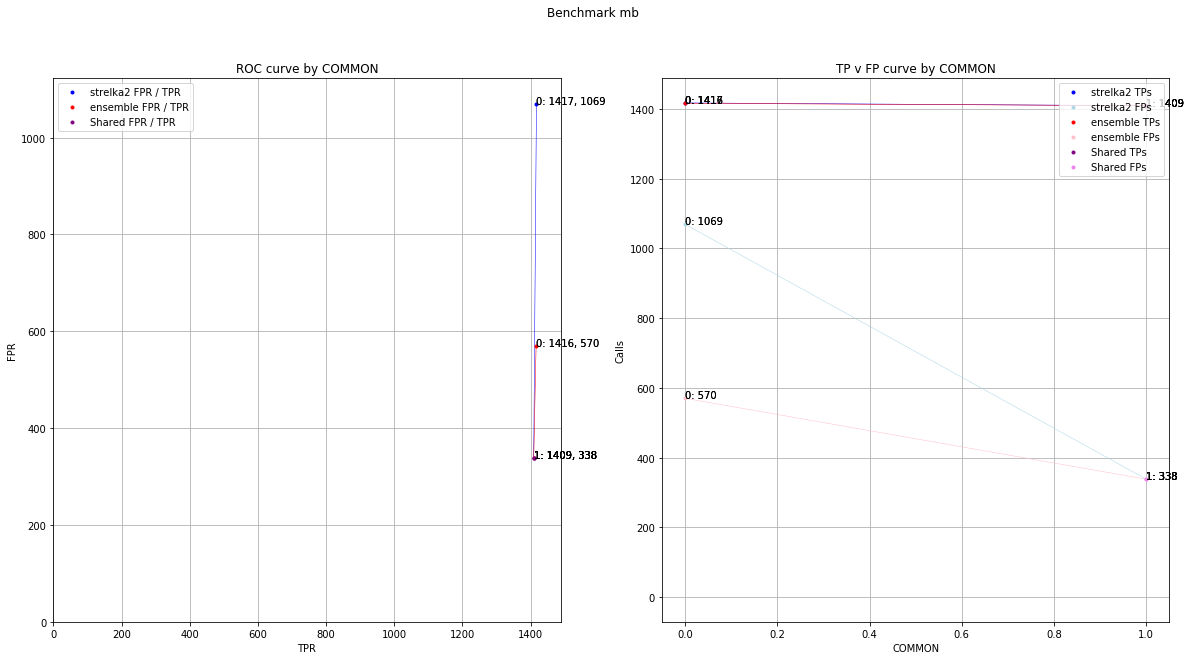

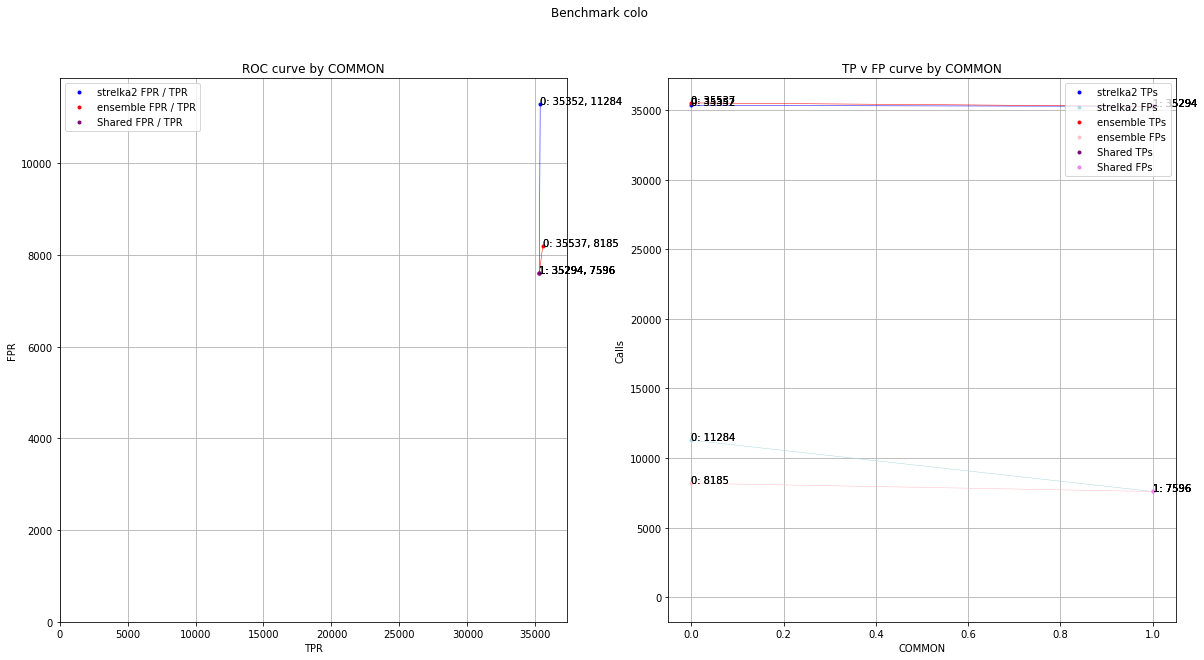

In [10]:
def _is_common(x):
    return 1 if (x[f'{l}_typ'] in ['tp', 'fp'] and x[f'{r}_typ'] in ['tp', 'fp']) else 0

data[f'common'] = data.apply(_is_common, axis=1)
#len(data[data['common'] == 1][data['e_typ'].isin(['tp', 'fp'])]), \
#len(data[data['common'] == 1][data['s_typ'].isin(['tp', 'fp'])])

plot_roc(data, 'common', start=0, end=1, step=1, label_step=1, show_values=False)

Plotting mb
Plotting colo


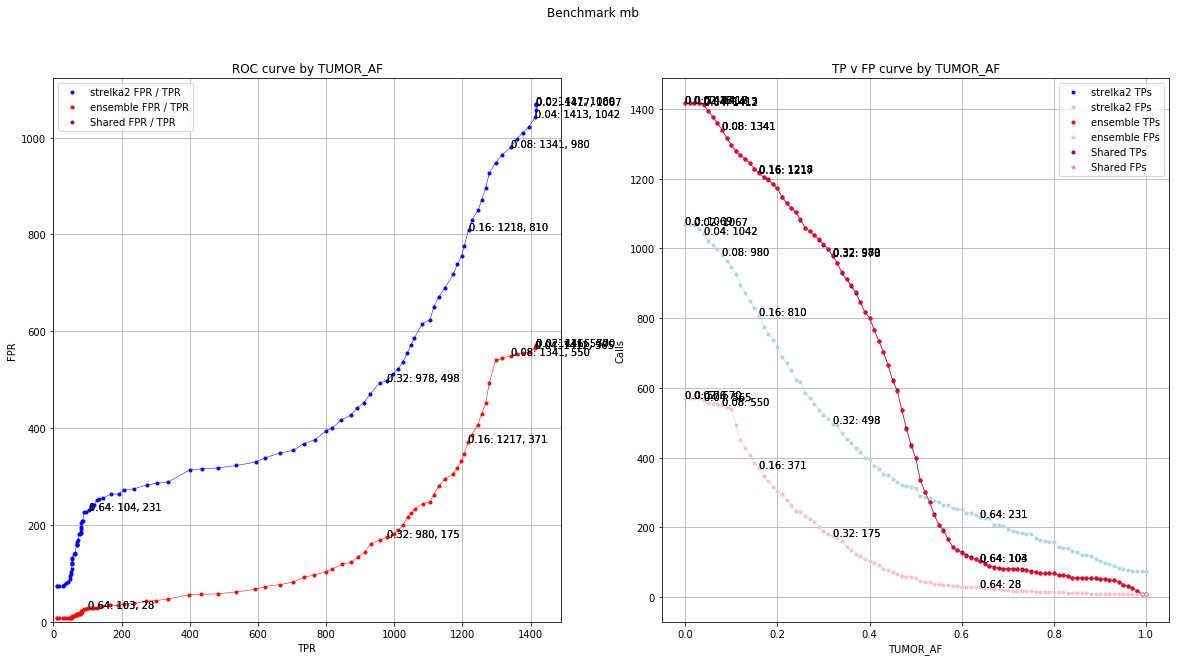

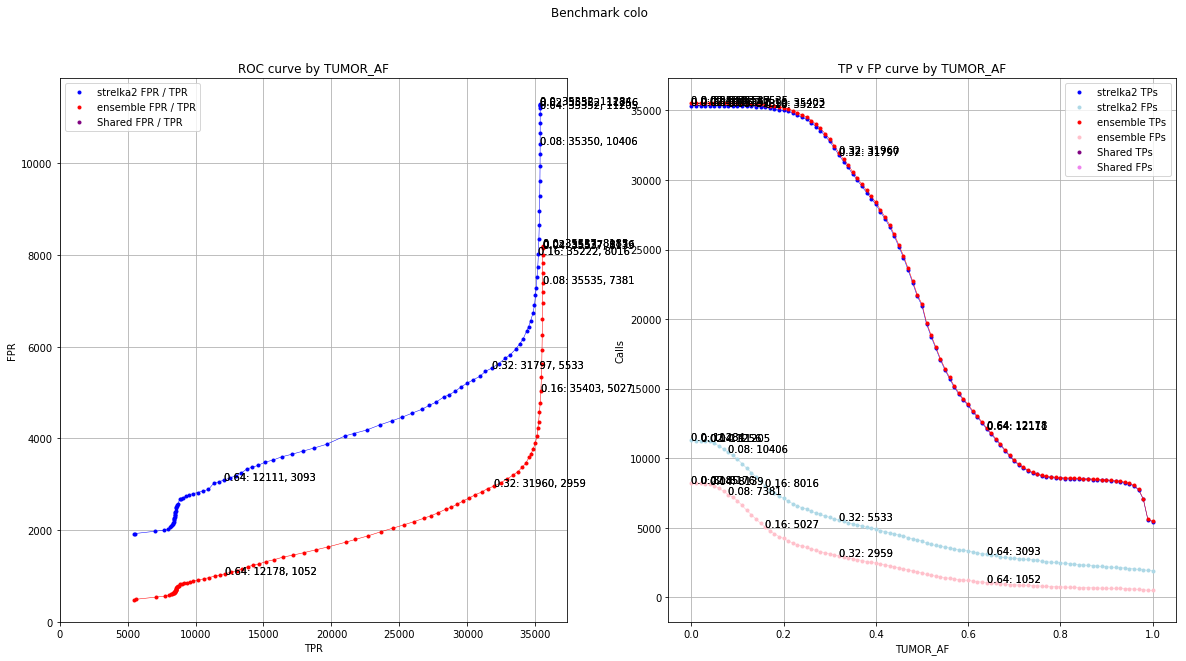

In [11]:
# def filt_fn(v):
#     r = True
#     if v['TUMOR_AF'] and v['TUMOR_AF'] < 0.2:
#         r = False
#     if v['TUMOR_DP'] and v['TUMOR_DP'] < 23:
#         r = False
#     return r
filt_fn = None

plot_roc(data, 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, show_values=True, filt_fn=filt_fn)
pass

In [4]:
def roc_points(bn, df, f, start=None, end=None, step=None, label_step=None):
    print(f'Calc roc points for {bn} {f}')
    bdf = df.loc[bn]

    start = start or min(bdf[f])
    end = end or max(bdf[f])
    step = step or (0.01 if (end-start)/10<1 else 1)
    label_step = step * 10
    print(f'  calculating for {f} thresholds from {start} to {end} with step of {step}')

    tps, fps, precs, recalls = [], [], [], []

    vals = np.arange(start, end + step, step)
    for val in vals:
        val_df = bdf[bdf[f] >= val]
        tp = len(val_df[val_df['typ'] == 'tp'])
        fn = len(val_df[val_df['typ'] == 'fn'])
        fp = len(val_df[val_df['typ'] == 'fp'])

        tps.append(tp)
        fps.append(fp)
        called = tp + fp
        precs.append(tp / called if called else 0)
        truth = tp + fn
        recalls.append(tp / truth if truth else 0)

#         # Labels
#         for v, tp, fp in zip(vals, tps, fps):
#             label = f'{v}'
#             if v % label_step == 0:  #and k == l and v == lfs[0][0]:
#                 print('Annotating')
#                 roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(fp, tp))
#                 tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
#                 tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
#         plt.grid()
    return vals, tps, fps, label_step
    
roc_pts_by_f_by_bn = defaultdict(dict)
for bn in benchmarks_names:
    roc_pts_by_f_by_bn[bn]['TUMOR_AF'] = roc_points(bn, data, 'TUMOR_AF')
    roc_pts_by_f_by_bn[bn]['TUMOR_DP'] = roc_points(bn, data, 'TUMOR_DP', end=500)
    roc_pts_by_f_by_bn[bn]['TUMOR_MQ'] = roc_points(bn, data, 'TUMOR_MQ')

Calc roc points for mb TUMOR_AF
  calculating for TUMOR_AF thresholds from 0.03424660116434097 to 1.0735299587249756 with step of 0.01
Calc roc points for mb TUMOR_DP
  calculating for TUMOR_DP thresholds from 6.0 to 333.0 with step of 1
Calc roc points for mb TUMOR_MQ
  calculating for TUMOR_MQ thresholds from 18.399999618530273 to 60.0 with step of 1
Calc roc points for colo TUMOR_AF
  calculating for TUMOR_AF thresholds from 0.011774499900639057 to 1.0 with step of 0.01
Calc roc points for colo TUMOR_DP
  calculating for TUMOR_DP thresholds from 2.0 to 7409.0 with step of 1
Calc roc points for colo TUMOR_MQ
  calculating for TUMOR_MQ thresholds from 13.75 to 60.0 with step of 1


In [22]:
roc_pts_by_f_by_bn['colo']['TUMOR_AF'][1][50], \
roc_pts_by_f_by_bn['colo']['TUMOR_DP'][1][50], \
roc_pts_by_f_by_bn['colo']['TUMOR_MQ'][1][50]

(19955, 19955, 19955)

In [14]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory
from ipywidgets import *

tp_colors = ['blue', 'red', 'green']
fp_colors = ['lightblue', 'pink', 'lightgreen']

def plot_roc_2(roc_pts_by_f_by_bn):
    for j, (bn, roc_pts_by_f) in enumerate(roc_pts_by_f_by_bn.items()):
#        print(f'Plotting {bn}')

        fig = plt.figure(figsize=(20, 10*(1+len(roc_pts_by_f))//2))
        grid = gridspec.GridSpec(2, (1+len(roc_pts_by_f))//2)
        plt.suptitle(f'Benchmark {bn}')
        
        roc_ax = plt.subplot(grid[0], label=f'ROC', title=f'ROC curve')
        roc_ax.set_xlabel('TPR')
        roc_ax.set_ylabel('FPR')

        for i, (f, [vals, tps, fps, label_step]) in enumerate(roc_pts_by_f.items()):
 #           print(f'   Plotting {f}')
            # ROC curve plot
            roc_ax.plot(tps, fps, '-', c=tp_colors[i], lw=0.5)
            roc_ax.plot(tps, fps, '.', c=tp_colors[i], label=f'{f}')
            plt.grid()
            
            # TP/FP plot
            tp_fp_ax = plt.subplot(grid[1+i], label=f'TP v FP', title=f'TP v FP curve by {f}')
            tp_fp_ax.set_xlabel(f'{f}')
            tp_fp_ax.set_ylabel('Calls')

            tp_fp_ax.plot(vals, tps, '-', c=tp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, tps, '.', c=tp_colors[i], label=f'{f} TPs')
            tp_fp_ax.plot(vals, fps, '-', c=fp_colors[i], lw=0.5)
            tp_fp_ax.plot(vals, fps, '.', c=fp_colors[i], label=f'{f} FPs')
            plt.grid()
    
#            max_tp_f = max(tps)
#            max_fp_f = max(fps)

#            delta = (end - start) * 0.05
#            tp_fp_ax.set_xlim([fd['start']-delta, fd['end']+delta])

#            max_y = max(max_tp_f, max_fp_f)
#            delta = max_y*0.05
#            tp_fp_ax.set_ylim([-delta, max_y+delta])
#            print(f'   Setting legend TP-FP {f}')
            tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=1)
            plt.grid()

            # Labels
#            print(f'   Annotating {f}')
            for v, tp, fp in zip(vals, tps, fps):
                label = f'{v}'
                if v % label_step == 0:  #and k == l and v == lfs[0][0]:
                    roc_ax.annotate(f'{label}: {fp}, {tp}', xy=(tp, fp))
                    tp_fp_ax.annotate(f'{label}: {tp}', xy=(v, tp))
                    tp_fp_ax.annotate(f'{label}: {fp}', xy=(v, fp))
            plt.grid()
        
        # ROC curve limits
 #       max_tp = max(max(vs) for vs in tps_by_f.values())
 #       max_fp = max(max(vs) for vs in fps_by_f.values())

 #       delta = max_tp*0.05
 #       roc_ax.set_xlim([0, max_tp+delta])

 #       delta = max_fp*0.05
 #       roc_ax.set_ylim([0, max_fp+delta])

 #       print(f'   Setting legend ROC')
        roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
        plt.grid()

def _plot(af, dp, mq):
    min_by_f = {
        'TUMOR_AF': af,
        'TUMOR_DP': dp,
        'TUMOR_MQ': mq,
    }
    r = defaultdict(dict)
    for bn, roc_pts_by_f in roc_pts_by_f_by_bn.items():
        for f, (vals, tps, fps, label_step) in roc_pts_by_f.items():
            triplets = [(v, tp, fp) for (v, tp, fp) in zip(vals, tps, fps) if v >= min_by_f[f]]
            vals, tps, fps = zip(*triplets)
            r[bn][f] = vals, tps, fps, label_step

    plot_roc_2(r)

interact(_plot, af=0.01, dp=10, mq=20)

interactive(children=(FloatSlider(value=0.01, description='af', max=0.03, min=-0.01), IntSlider(value=10, description='dp', max=30, min=-10), IntSlider(value=20, description='mq', max=60, min=-20), Output()), _dom_classes=('widget-interact',))

<function __main__._plot>

In [ ]:
dfc = df[df['caller'] == 'strelka2']
d = dfc[dfc['called_with_mm2'] == True]

import seaborn as sns
sns.set(rc={'figure.figsize':(15, 10)})

pd.set_option('display.max_columns', None)
g2 = sns.jointplot(x="mm2_TUMOR_AF", y="mm2_TUMOR_DP", data=d, kind="kde", kde_kws={'clip':((0, 1), (0, 200))});
#g2.set(xlim=(0, 1), ylim=(0, 200))
#g = sns.distplot(dfc_mm2['mm2_TUMOR_AF'][1000:], rug=True, bins=50)
#g.set(xlim=(0, 1))

